In [7]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

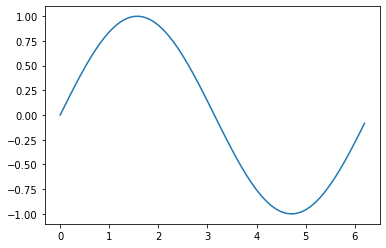

In [8]:
x = np.arange(0, 2*np.pi, .1)
y = np.sin(x)
plt.plot(x, y)

In [1]:
%load_ext cython


In [2]:
import numpy as np
import scipy.optimize as optimize
def chisq_py(func, x, data, params) -> np.ndarray:
    return np.sum((func(x, params) - data)**2)

def sin_func_py(x, params):
    return params[0]*np.sin(params[1]*x + params[2]) + params[3]

def fit(func, chisq, x, y, guess):
    fit_params = optimize.minimize(
                fun = lambda params: chisq_py(func, x, y, params),
                x0 = guess,
                jac = "3-point",
                method="SLSQP").x
    return fit_params

def fit_min(chisq, x, y, guess):
    fit_params = optimize.minimize(
                fun = lambda params: chisq(x, y, params),
                x0 = guess,
                jac = "3-point",
                method="SLSQP").x
    return fit_params


def sfit(func, chisq, x, y, guess):
    return optimize.basinhopping(
                func = lambda params: chisq_py(func, x, y, params),
                x0 = guess,
                T = 1,
                # minimizer_kwargs={"jac": lambda params: chisq_jac(sin_jac, x, y_data, params)}
        ).x

def sfit_2(chisqf, x, y, guess):
    return optimize.basinhopping(
                func = lambda params: chisqf(x, y, params),
                x0 = guess,
                T = 1,
                # minimizer_kwargs={"jac": lambda params: chisq_jac(sin_jac, x, y_data, params)}
        ).x
    
    
def predict(func, x, params):
    return func(x, *params)


In [26]:
guess = [.5, .5, 0, 0]
%timeit fit(sin_func_py, chisq_py, x, y, guess)

4.05 ms ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
%%cython -a
import time
import numpy as np
cimport numpy as np
cimport cython
np.import_array()


ctypedef np.float_t DTYPE_t

cdef extern from "math.h":
    cpdef double sin(double x)

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef np.ndarray[double, ndim=1] sin_func(np.ndarray[double, ndim=1] arr, np.ndarray[double, ndim=1] params):
    cdef int shape = len(arr)
    cdef np.ndarray[double, ndim=1] y = np.zeros(shape)
    for k in range(shape):
        y[k] = params[0]*sin(params[1]*arr[k]+params[2]) + params[3]
    return y

In [37]:
x = np.linspace(0, 10, 1_000_000).astype(np.float64)
x0 = np.array([5, 2, 6]).astype(np.float64)

sin_func(x, x0)

%timeit sin_func(x, x0)

4.03 ms ± 84.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


4.28 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%cython -a
import time
import numpy as np
cimport numpy as np
cimport cython
np.import_array()


ctypedef np.float_t DTYPE_t

cdef extern from "math.h":
    cpdef double sin(double x)

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef np.ndarray[DTYPE_t, ndim=1] sin_func(np.ndarray[DTYPE_t, ndim=1] arr, np.ndarray[DTYPE_t, ndim=1] params):
    cdef int shape = len(arr)
    cdef np.ndarray[DTYPE_t, ndim=1] y = np.array(shape)
    for k in range(shape):
        y[k] = params[0]*sin(params[1]*arr[k]+params[2]) + params[3]
    return y

# @cython.boundscheck(False)
# @cython.wraparound(False)
# cpdef inline double chisq(func, np.ndarray[DTYPE_t, ndim=1] x, np.ndarray[DTYPE_t, ndim=1] data, np.ndarray[DTYPE_t, ndim=1] params):
#     return sum((func(x, params) - data)**2)

ctypedef np.ndarray[DTYPE_t, ndim=1] (*f_type)(np.ndarray[DTYPE_t, ndim=1], np.ndarray[DTYPE_t, ndim=1])

@cython.boundscheck(False)
@cython.wraparound(False)
cdef double chisq2(f_type func, np.ndarray[DTYPE_t, ndim=1] x, np.ndarray[DTYPE_t, ndim=1] data, np.ndarray[DTYPE_t, ndim=1] params):
    cdef double s = 0
    cdef np.ndarray[DTYPE_t, ndim=1] y = func(x, params)
    for i in range(len(x)):
        s += (y[i] - data[i])**2
    return s

# @cython.boundscheck(False)
# @cython.wraparound(False)
# cpdef double sin_func_min(np.ndarray[DTYPE_t, ndim=1] x, np.ndarray[DTYPE_t, ndim=1] data, np.ndarray[DTYPE_t, ndim=1] params):
#     return chisq2(sin_func, x, data, params)

In file included from /Users/4cd87a/.ipython/cython/_cython_magic_b206d0719b80e8aa0853b12fcf5f8149.c:706:
In file included from /Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
/Users/4cd87a/.ipython/cython/_cython_magic_b206d0719b80e8aa0853b12fcf5f8149.c:2264:15: warning: unused function '__pyx_f_46_cython_magic_b206d0719b80e8aa0853b12fc

In [10]:
guess = np.array([.5, .5, 0, 0])

%timeit sfit(sin_func_py, chisq_py, x, y, guess)

405 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
def sin_func_min_py(x, y, param):
    return chisq_py(sin_func_py, x, y, param)

def sin_func_min(x, y, param):
    return chisq_py(sin_func, x, y, param)

In [20]:
%timeit fit_min(sin_func_min_py, x, y, guess)

4.7 ms ± 706 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
sin_func(x, guess)

ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

In [26]:
fit_min(sin_func_min, x, y, guess)

ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

In [22]:
fit_min(sin_func_min, x, y, guess)

ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

Exception ignored in: '_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.chisq2'
Traceback (most recent call last):
  File "_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.pyx", line 17, in _cython_magic_788a54b41b54ddcb78e6885e7aee8e79.sin_func
ValueError: Buffer has wrong number of dimensions (expected 1, got 0)


ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

Exception ignored in: '_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.chisq2'
Traceback (most recent call last):
  File "_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.pyx", line 17, in _cython_magic_788a54b41b54ddcb78e6885e7aee8e79.sin_func
ValueError: Buffer has wrong number of dimensions (expected 1, got 0)


ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

Exception ignored in: '_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.chisq2'
Traceback (most recent call last):
  File "_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.pyx", line 17, in _cython_magic_788a54b41b54ddcb78e6885e7aee8e79.sin_func
ValueError: Buffer has wrong number of dimensions (expected 1, got 0)


ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

Exception ignored in: '_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.chisq2'
Traceback (most recent call last):
  File "_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.pyx", line 17, in _cython_magic_788a54b41b54ddcb78e6885e7aee8e79.sin_func
ValueError: Buffer has wrong number of dimensions (expected 1, got 0)


ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

Exception ignored in: '_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.chisq2'
Traceback (most recent call last):
  File "_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.pyx", line 17, in _cython_magic_788a54b41b54ddcb78e6885e7aee8e79.sin_func
ValueError: Buffer has wrong number of dimensions (expected 1, got 0)


ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

Exception ignored in: '_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.chisq2'
Traceback (most recent call last):
  File "_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.pyx", line 17, in _cython_magic_788a54b41b54ddcb78e6885e7aee8e79.sin_func
ValueError: Buffer has wrong number of dimensions (expected 1, got 0)


ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

Exception ignored in: '_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.chisq2'
Traceback (most recent call last):
  File "_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.pyx", line 17, in _cython_magic_788a54b41b54ddcb78e6885e7aee8e79.sin_func
ValueError: Buffer has wrong number of dimensions (expected 1, got 0)


ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

Exception ignored in: '_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.chisq2'
Traceback (most recent call last):
  File "_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.pyx", line 17, in _cython_magic_788a54b41b54ddcb78e6885e7aee8e79.sin_func
ValueError: Buffer has wrong number of dimensions (expected 1, got 0)


ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

Exception ignored in: '_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.chisq2'
Traceback (most recent call last):
  File "_cython_magic_788a54b41b54ddcb78e6885e7aee8e79.pyx", line 17, in _cython_magic_788a54b41b54ddcb78e6885e7aee8e79.sin_func
ValueError: Buffer has wrong number of dimensions (expected 1, got 0)


array([0.5, 0.5, 0. , 0. ])

In [ ]:
from scipy.optimize.cython_optimize import 

In [52]:
guess = np.array([.5, .5, 0, 0])
%timeit sfit(sin_func, chisq_py, x, y, guess)

323 ms ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
guess = np.array([.5, .5, 0, 0])
%timeit sfit(sin_func, chisq, x, y, guess)

379 ms ± 67.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%timeit sin_func_py(x, guess)

5.88 µs ± 25.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [49]:
%timeit sin_func(x, guess)

1.38 µs ± 11.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [60]:
x = np.arange(0, 2*np.pi, .1)
plt.plot(x, sin_func(x, guess))

ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

In [56]:
%%cython
cimport cython
import numpy as np
cimport numpy as np
np.import_array()

@cython.boundscheck(False)
@cython.wraparound(False)
cdef np.ndarray[np.float_t, ndim=1] sin_func(np.ndarray[np.float_t, ndim=1] x, float amp, float freq, float phase, float offset):
    return amp*np.sin(freq*x + phase) + offset




In file included from /Users/4cd87a/.ipython/cython/_cython_magic_b038c79b9784391dea814c931072503e.c:719:
In file included from /Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
/Users/4cd87a/.ipython/cython/_cython_magic_b038c79b9784391dea814c931072503e.c:1794:23: warning: unused function '__pyx_f_46_cython_magic_b038c79b9784391dea814c931

In [55]:
%timeit sin_func(x, *guess)

4.92 µs ± 130 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
guess = [.5, .5, 0, 0]
%timeit fit(sin_func, x, y, guess)

TypeError: fit() missing 1 required positional argument: 'guess'

In [28]:
guess = [.5, .5, 0, 0]
%timeit fit(sin_func, x, y, guess)

4.45 ms ± 734 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%timeit sin_func_py(x, *guess)

4.91 µs ± 202 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [24]:
%%cython
import time
import numpy
cimport numpy
cimport cython

ctypedef numpy.float_t DTYPE_t

cdef extern from "math.h":
    cpdef double sin(double x)
    
# @cython.boundscheck(False)
# @cython.wraparound(False)
# cpdef numpy.ndarray[DTYPE_t, ndim=1] sin_func(numpy.ndarray[DTYPE_t, ndim=1] arr, float* params amp, float freq, float phase, float offset):
#     for k in range(len(arr)):
#         arr[k] =amp*sin(freq*arr[k]+phase) + offset
    
#     return arr

ctypedef numpy.ndarray[DTYPE_t, ndim=1] (*f_type)(numpy.ndarray[DTYPE_t, ndim=1], numpy.ndarray[DTYPE_t, ndim=1])

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef numpy.ndarray[DTYPE_t, ndim=1] sin_func(numpy.ndarray[DTYPE_t, ndim=1] arr, double amp, double freq, double phase, double offset):
    for k in range(len(arr)):
        arr[k] = amp*sin(freq*arr[k]+phase) + offset
    return arr

# @cython.boundscheck(False)
# @cython.wraparound(False)
# cpdef numpy.ndarray[DTYPE_t, ndim=1] sin_func(numpy.ndarray[DTYPE_t, ndim=1] arr, numpy.ndarray[DTYPE_t, ndim=1] params):
#     for k in range(len(arr)):
#         arr[k] = params[0]*sin(params[1]*arr[k]+params[2]) + params[3]
    # return arr

# def sin_func_py(x, params):
#     return params[0]*numpy.sin(params[1]*x + params[2]) + params[3]

def sin_func_py(x, amp, freq, phase, offset):
    return amp*numpy.sin(freq*x + phase) + offset

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double chisq(func, numpy.ndarray[DTYPE_t, ndim=1] x, numpy.ndarray[DTYPE_t, ndim=1] data, numpy.ndarray[DTYPE_t, ndim=1] params):
    return numpy.sum((func(x, params) - data)**2)

import scipy.optimize as optimize

def chisq_py(func, x, data, params):
    return sum((func(x, *params) - data)**2)

def sfit(func, x, y, guess):
    return optimize.basinhopping(
                func = lambda params: chisq_py(func, x, y, params),
                x0 = guess,
                T = 1,
                # minimizer_kwargs={"jac": lambda params: chisq_jac(sin_jac, x, y_data, params)}
        ).x

def fit(func, x, y, guess):
    fit_params = optimize.minimize(
                fun = lambda params: chisq_py(func, x, y, params),
                x0 = guess,
                jac = "3-point",
                method="SLSQP").x
    return fit_params

    
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double chisq_f(numpy.ndarray[DTYPE_t, ndim=1] x, numpy.ndarray[DTYPE_t, ndim=1] data, numpy.ndarray[DTYPE_t, ndim=1] params):
    for k in range(len(data)):
        x[k] = params[0]*sin(params[1]*x[k]+params[2]) + params[3]

    return sum((x - data)**2)

In file included from /Users/4cd87a/.ipython/cython/_cython_magic_5a1d5cd713c3aaad08e8bce1e2190613.c:707:
In file included from /Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/4cd87a/opt/anaconda3/envs/phd_mask/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
1 warning generated.


In [16]:
guess = np.array([.5, .5, 0, 0])
guess = [.5, .5, 0, 0]

In [38]:
%timeit sin_func(x, guess)

572 ns ± 11.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [39]:
%timeit sin_func_py(x, guess)

5.58 µs ± 50.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [93]:
def sin_func_py(x, amp, freq, phase, offset):
    return amp*np.sin(freq*x + phase) + offset

%timeit sin_func_py(x, *guess)

4.89 µs ± 350 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [88]:
%timeit fit(sin_func_py, x, y, guess)

1.34 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [23]:
%timeit fit(sin_func, x, y, guess)

434 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
%timeit fit(sin_func_py, x, y, guess)

450 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
%timeit fit(sin_func, x, y, guess)

443 µs ± 9.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
sfit(sin_func_py, x, y, guess)

array([ 6.58063209,  2.95088511,  0.0532956 , -0.34882249])

In [34]:
%timeit sfit_2(chisq_f, x, y, guess)

478 ms ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
guess = [.5, .5, 0, 0]
%timeit fit(sin_func, x, y, guess)

In [1]:
def f_score_py(x):
    return (x-1)**2

def simple_fit_py(x0):
    step = 1
    direct = 1
    score = 1
    old_score = 1e6
    
    while score>1e-5:
        x = x0 + step*direct
        score = f_score_py(x)
        # print(x, score)
        if score<old_score:
            x0 = x
        else:
            direct = -1*direct
            step = step/2
    
    return x0

In [77]:
%timeit simple_fit_py(-13.55)

51.2 ms ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%cython

cpdef double f_score(double x):
    return (x-1)**2

cpdef double simple_fit(double x0):
    cdef double step = 1.0
    cdef double direct = 1
    cdef double old_score = f_score(x0+step)
    cdef double score = old_score
    cdef double x = x0 + step
    cdef double dx = 1
    cdef int j = 10
    while score>1e-5 and j>0:
        j = j - 1
        x = x0 + direct*dx
        score = f_score(x)
        print(x, score)
        if score<old_score:
            if score-old_score==0:
                return x
            dx = step#*abs(dx)#/(score-old_score)
            x0 = x
        else:
            direct = -1*direct
            step = step/2
            dx = dx/2
    
    return x0

In [10]:
simple_fit(-13.55)

-12.55 183.60250000000002
-14.05 226.50250000000003
-13.3 204.49
-13.675 215.35562500000003
-13.4875 209.88765625000002
-13.58125 212.61285156250003
-13.534375 211.248056640625
-13.5578125 211.92990478515628
-13.54609375 211.58884338378908
-13.551953125 211.7593397521973


-13.55

In [95]:
%timeit simple_fit(-13.55)

ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: '_cython_magic_d33e5aada1040c975bde92b13d65fed9.simple_fit'
Traceback (most recent call last):
  File "<magic-timeit>", line 1, in inner
ZeroDivisionError: float division


4.87 ms ± 907 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
